In [86]:
import os
import re
from itertools import groupby
pattern = re.compile("(.*)_(.*)_psnr.log")
def extract_info(path):
    match = pattern.match(path)
    return (match.group(1), match.group(2))



[(root, _, files), *_] = os.walk("logs")
files = [(f, extract_info(f)) for f in files]
print("found", len(files), "files")

groups = groupby(sorted(files), key=lambda x: x[1])

logs = []
for invid, triples in groups:
    for (infile, (invid, codec)) in triples:
        with open(f"logs/{infile}") as infp:
            logs.append((invid, codec, infp.readlines()))


print(len(logs))

found 25 files
25


25


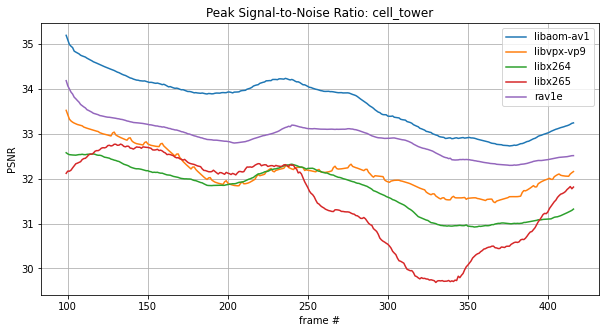

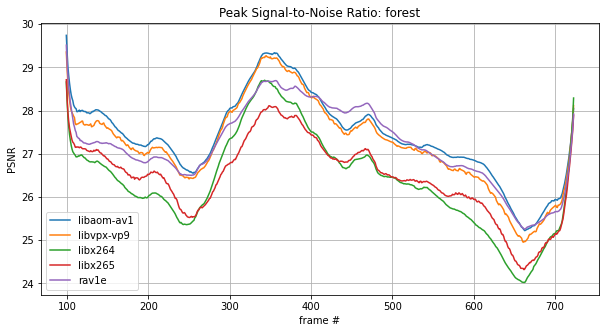

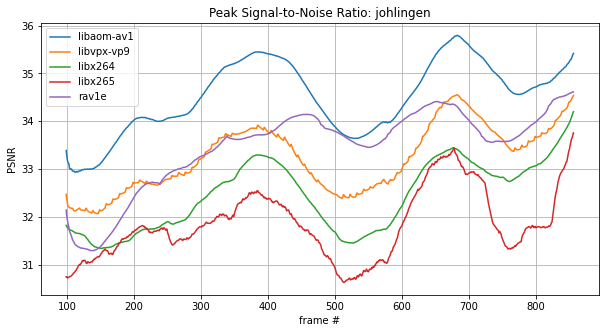

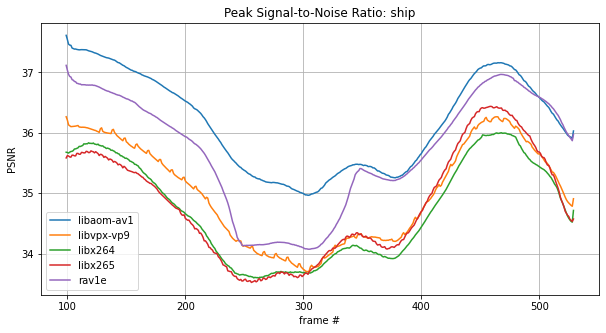

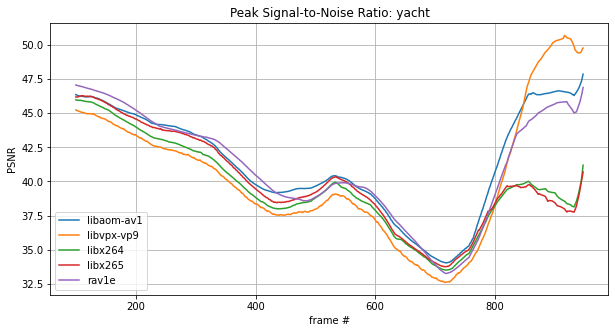

In [99]:
import re
from pandas import DataFrame
import matplotlib.pyplot as plt
from itertools import groupby
import seaborn as sns
# n:1 mse_avg:23.20 mse_y:29.59 mse_u:8.02 mse_v:12.82 psnr_avg:34.48 psnr_y:33.42 psnr_u:39.09 psnr_v:37.05 
pattern = re.compile("n:(\d+) mse_avg:(\d+\.\d+) .* psnr_avg:(\d+\.\d+|inf)")

def read_log(loglines):
    matches = [pattern.match(logline) for logline in loglines]
    metrics = [(float(match.group(2)), float(match.group(3))) for match in matches]
    return DataFrame(metrics, columns=[f"mse", f"psnr"])

dataframes = [(invid, codec, read_log(loglines)) for (invid, codec, loglines) in logs]

groups = groupby(dataframes, key=lambda x: x[0])

for (invid, triples) in groups:
    triples = list(triples)
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for (invid, codec, df) in triples:
        df[codec] = df[["psnr"]]
        mean = df[codec].rolling(100).mean()
        mean.plot(ax=ax, title=f"Peak Signal-to-Noise Ratio: {invid}", legend=True, grid=True, xlabel="frame #", ylabel="PSNR")
    fig.savefig(f"psnr_{invid}.jpg")
print(len(dataframes))

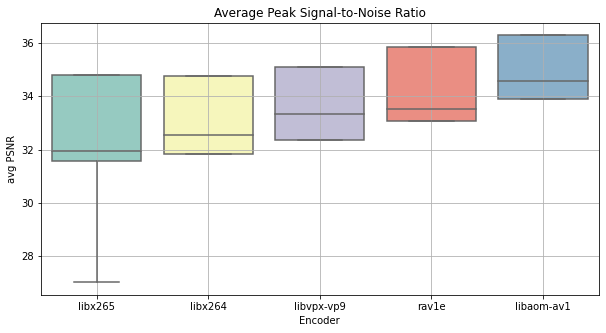

In [89]:
import seaborn as sns
groups = groupby(dataframes, key=lambda x: x[0])

mean_psnr = []
for (invid, triples) in groups:
    triples = list(triples)
    for (invid, codec, df) in triples:
        mean_psnr.append((codec, float(df[["psnr"]].sum()), len(df[["psnr"]])))

mean_psnr = DataFrame(mean_psnr, columns=["encoder", "psnr", "len"])
mean_psnr["avg"] = mean_psnr["psnr"] / mean_psnr["len"]

fig, ax = plt.subplots(figsize=(10, 5))
order=["libx265", "libx264", "libvpx-vp9", "rav1e", "libaom-av1"]
plot = sns.boxplot(x="encoder", y="avg", data=mean_psnr, order=order, showfliers=False, ax=ax, palette="Set3") 
plot.set(
    title="Average Peak Signal-to-Noise Ratio",
    xlabel='Encoder',
    ylabel='avg PSNR'
)

ax.yaxis.grid(True)
ax.xaxis.grid(True)

fig.savefig(f"psnr_{invid}.jpg")